<a href="https://colab.research.google.com/github/plue1011/ObjectDetection/blob/master/SSD_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# パッケージのimport
from math import sqrt
from itertools import product
import cv2
import time

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optimizers
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!tar -zxf /content/drive/My\ Drive/study/CNN/dataset/RoadDamageDataset.tar.gz

# match

In [0]:
def point_form(boxes):
    """ Convert prior_boxes to (xmin, ymin, xmax, ymax)
    representation for comparison to point form ground truth data.
    Args:
        boxes: (tensor) center-size default boxes from priorbox layers.
    Return:
        boxes: (tensor) Converted xmin, ymin, xmax, ymax form of boxes.
    """
    return torch.cat((boxes[:, :2] - boxes[:, 2:]/2,     # xmin, ymin
                     boxes[:, :2] + boxes[:, 2:]/2), 1)  # xmax, ymax

In [0]:
def center_size(boxes):
    """ Convert prior_boxes to (cx, cy, w, h)
    representation for comparison to center-size form ground truth data.
    Args:
        boxes: (tensor) point_form boxes
    Return:
        boxes: (tensor) Converted xmin, ymin, xmax, ymax form of boxes.
    """
    return torch.cat((boxes[:, 2:] + boxes[:, :2])/2,  # cx, cy
                     boxes[:, 2:] - boxes[:, :2], 1)  # w, h

In [0]:
def intersect(box_a, box_b):
    """ We resize both tensors to [A,B,2] without new malloc:
    [A,2] -> [A,1,2] -> [A,B,2]
    [B,2] -> [1,B,2] -> [A,B,2]
    Then we compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """
    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

In [0]:
def jaccard(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.  Here we operate on
    ground truth boxes and default boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
        box_b: (tensor) Prior boxes from priorbox layers, Shape: [num_priors,4]
    Return:
        jaccard overlap: (tensor) Shape: [box_a.size(0), box_b.size(0)]
    """
    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) * (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
    area_b = ((box_b[:, 2]-box_b[:, 0]) * (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

In [0]:
def encode(matched, priors, variances):
    """Encode the variances from the priorbox layers into the ground truth boxes
    we have matched (based on jaccard overlap) with the prior boxes.
    Args:
        matched: (tensor) Coords of ground truth for each prior in point-form
            Shape: [num_priors, 4].
        priors: (tensor) Prior boxes in center-offset form
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        encoded boxes (tensor), Shape: [num_priors, 4]
    """

    # dist b/t match center and prior's center
    g_cxcy = (matched[:, :2] + matched[:, 2:])/2 - priors[:, :2]
    # encode variance
    g_cxcy /= (variances[0] * priors[:, 2:])
    # match wh / prior wh
    g_wh = (matched[:, 2:] - matched[:, :2]) / priors[:, 2:]
    g_wh = torch.log(g_wh) / variances[1]
    # return target for smooth_l1_loss
    return torch.cat([g_cxcy, g_wh], 1)  # [num_priors,4]

In [0]:
def match(threshold, truths, priors, variances, labels, loc_t, conf_t, idx):
    """Match each prior box with the ground truth box of the highest jaccard
    overlap, encode the bounding boxes, then return the matched indices
    corresponding to both confidence and location preds.
    Args:
        threshold: (float) The overlap threshold used when mathing boxes.
        truths: (tensor) Ground truth boxes, Shape: [num_obj, num_priors].
        priors: (tensor) Prior boxes from priorbox layers, Shape: [n_priors,4].
        variances: (tensor) Variances corresponding to each prior coord,
            Shape: [num_priors, 4].
        labels: (tensor) All the class labels for the image, Shape: [num_obj].
        loc_t: (tensor) Tensor to be filled w/ endcoded location targets.
        conf_t: (tensor) Tensor to be filled w/ matched indices for conf preds.
        idx: (int) current batch index
    Return:
        The matched indices corresponding to 1)location and 2)confidence preds.
    """
    # jaccard index
    overlaps = jaccard(
        truths,
        point_form(priors)
    )
    # (Bipartite Matching)
    # [1,num_objects] best prior for each ground truth
    best_prior_overlap, best_prior_idx = overlaps.max(1, keepdim=True)
    # [1,num_priors] best ground truth for each prior
    best_truth_overlap, best_truth_idx = overlaps.max(0, keepdim=True)
    best_truth_idx.squeeze_(0)
    best_truth_overlap.squeeze_(0)
    best_prior_idx.squeeze_(1)
    best_prior_overlap.squeeze_(1)
    best_truth_overlap.index_fill_(0, best_prior_idx, 2)  # ensure best prior
    # TODO refactor: index  best_prior_idx with long tensor
    # ensure every gt matches with its prior of max overlap
    for j in range(best_prior_idx.size(0)):
        best_truth_idx[best_prior_idx[j]] = j
    matches = truths[best_truth_idx]          # Shape: [num_priors,4]
    conf = labels[best_truth_idx] + 1         # Shape: [num_priors]
    conf[best_truth_overlap < threshold] = 0  # label as background
    loc = encode(matches, priors, variances)
    loc_t[idx] = loc    # [num_priors,4] encoded offsets to learn
    conf_t[idx] = conf  # [num_priors] top class label for each prior

# 誤差関数

In [0]:
class MultiBoxLoss(nn.Module):
    """SSDの損失関数のクラスです。"""

    def __init__(self, jaccard_thresh=0.5, neg_pos=3, device='cpu'):
        super(MultiBoxLoss, self).__init__()
        self.jaccard_thresh = jaccard_thresh  # 0.5 関数matchのjaccard係数の閾値
        self.negpos_ratio = neg_pos  # 3:1 Hard Negative Miningの負と正の比率
        self.device = device  # CPUとGPUのいずれで計算するのか

    def forward(self, predictions, targets):
        """
        損失関数の計算。

        Parameters
        ----------
        predictions : SSD netの訓練時の出力(tuple)
            (loc=torch.Size([num_batch, 8732, 4]), conf=torch.Size([num_batch, 8732, 21]), dbox_list=torch.Size [8732,4])。

        targets : [num_batch, num_objs, 5]
            5は正解のアノテーション情報[xmin, ymin, xmax, ymax, label_ind]を示す

        Returns
        -------
        loss_l : テンソル
            locの損失の値
        loss_c : テンソル
            confの損失の値

        """

        # SSDモデルの出力がタプルになっているので、個々にばらす
        loc_data, conf_data, dbox_list = predictions

        # 要素数を把握
        num_batch = loc_data.size(0)  # ミニバッチのサイズ
        num_dbox = loc_data.size(1)  # DBoxの数 = 8732
        num_classes = conf_data.size(2)  # クラス数 = 21

        # 損失の計算に使用するものを格納する変数を作成
        # conf_t_label：各DBoxに一番近い正解のBBoxのラベルを格納させる
        # loc_t:各DBoxに一番近い正解のBBoxの位置情報を格納させる
        conf_t_label = torch.LongTensor(num_batch, num_dbox).to(self.device)
        loc_t = torch.Tensor(num_batch, num_dbox, 4).to(self.device)

        # loc_tとconf_t_labelに、
        # DBoxと正解アノテーションtargetsをmatchさせた結果を上書きする
        for idx in range(num_batch):  # ミニバッチでループ

            # 現在のミニバッチの正解アノテーションのBBoxとラベルを取得
            truths = targets[idx][:, :-1].to(self.device)  # BBox
            # ラベル [物体1のラベル, 物体2のラベル, …]
            labels = targets[idx][:, -1].to(self.device)

            # デフォルトボックスを新たな変数で用意
            dbox = dbox_list.to(self.device)

            # 関数matchを実行し、loc_tとconf_t_labelの内容を更新する
            # （詳細）
            # loc_t:各DBoxに一番近い正解のBBoxの位置情報が上書きされる
            # conf_t_label：各DBoxに一番近いBBoxのラベルが上書きされる
            # ただし、一番近いBBoxとのjaccard overlapが0.5より小さい場合は
            # 正解BBoxのラベルconf_t_labelは背景クラスの0とする
            variance = [0.1, 0.2]
            # このvarianceはDBoxからBBoxに補正計算する際に使用する式の係数です
            match(self.jaccard_thresh, truths, dbox, variance, labels, loc_t, conf_t_label, idx)

        # ----------
        # 位置の損失：loss_lを計算
        # Smooth L1関数で損失を計算する。ただし、物体を発見したDBoxのオフセットのみを計算する
        # ----------
        # 物体を検出したBBoxを取り出すマスクを作成
        pos_mask = conf_t_label > 0  # torch.Size([num_batch, 8732])

        # pos_maskをloc_dataのサイズに変形
        pos_idx = pos_mask.unsqueeze(pos_mask.dim()).expand_as(loc_data)

        # Positive DBoxのloc_dataと、教師データloc_tを取得
        loc_p = loc_data[pos_idx].view(-1, 4)
        loc_t = loc_t[pos_idx].view(-1, 4)

        # 物体を発見したPositive DBoxのオフセット情報loc_tの損失（誤差）を計算
        loss_l = F.smooth_l1_loss(loc_p, loc_t, reduction='sum')

        # ----------
        # クラス予測の損失：loss_cを計算
        # 交差エントロピー誤差関数で損失を計算する。ただし、背景クラスが正解であるDBoxが圧倒的に多いので、
        # Hard Negative Miningを実施し、物体発見DBoxと背景クラスDBoxの比が1:3になるようにする。
        # そこで背景クラスDBoxと予想したもののうち、損失が小さいものは、クラス予測の損失から除く
        # ----------
        batch_conf = conf_data.view(-1, num_classes)

        # クラス予測の損失を関数を計算(reduction='none'にして、和をとらず、次元をつぶさない)
        loss_c = F.cross_entropy(
            batch_conf, conf_t_label.view(-1), reduction='none')

        # -----------------
        # これからNegative DBoxのうち、Hard Negative Miningで抽出するものを求めるマスクを作成します
        # -----------------

        # 物体発見したPositive DBoxの損失を0にする
        # （注意）物体はlabelが1以上になっている。ラベル0は背景。
        num_pos = pos_mask.long().sum(1, keepdim=True)  # ミニバッチごとの物体クラス予測の数
        loss_c = loss_c.view(num_batch, -1)  # torch.Size([num_batch, 8732])
        loss_c[pos_mask] = 0  # 物体を発見したDBoxは損失0とする

        # Hard Negative Miningを実施する
        # 各DBoxの損失の大きさloss_cの順位であるidx_rankを求める
        _, loss_idx = loss_c.sort(1, descending=True)
        _, idx_rank = loss_idx.sort(1)

        # （注釈）
        # 実装コードが特殊で直感的ではないです。
        # 上記2行は、要は各DBoxに対して、損失の大きさが何番目なのかの情報を
        # 変数idx_rankとして高速に取得したいというコードです。
        #
        # DBOXの損失値の大きい方から降順に並べ、DBoxの降順のindexをloss_idxに格納。
        # 損失の大きさloss_cの順位であるidx_rankを求める。
        # ここで、
        # 降順になった配列indexであるloss_idxを、0から8732まで昇順に並べ直すためには、
        # 何番目のloss_idxのインデックスをとってきたら良いのかを示すのが、idx_rankである。
        # 例えば、
        # idx_rankの要素0番目 = idx_rank[0]を求めるには、loss_idxの値が0の要素、
        # つまりloss_idx[?}=0 の、?は何番かを求めることになる。ここで、? = idx_rank[0]である。
        # いま、loss_idx[?]=0の0は、元のloss_cの要素の0番目という意味である。
        # つまり?は、元のloss_cの要素0番目は、降順に並び替えられたloss_idxの何番目ですか
        # を求めていることになり、 結果、
        # ? = idx_rank[0] はloss_cの要素0番目が、降順の何番目かを示すことになる。

        # 背景のDBoxの数num_negを決める。HardNegative Miningにより、
        # 物体発見のDBoxの数num_posの3倍（self.negpos_ratio倍）とする。
        # ただし、万が一、DBoxの数を超える場合は、DBoxの数を上限とする
        num_neg = torch.clamp(num_pos*self.negpos_ratio, max=num_dbox)

        # idx_rankは各DBoxの損失の大きさが上から何番目なのかが入っている
        # 背景のDBoxの数num_negよりも、順位が低い（すなわち損失が大きい）DBoxを取るマスク作成
        # torch.Size([num_batch, 8732])
        neg_mask = idx_rank < (num_neg).expand_as(idx_rank)

        # -----------------
        # （終了）これからNegative DBoxのうち、Hard Negative Miningで抽出するものを求めるマスクを作成します
        # -----------------

        # マスクの形を整形し、conf_dataに合わせる
        # pos_idx_maskはPositive DBoxのconfを取り出すマスクです
        # neg_idx_maskはHard Negative Miningで抽出したNegative DBoxのconfを取り出すマスクです
        # pos_mask：torch.Size([num_batch, 8732])→pos_idx_mask：torch.Size([num_batch, 8732, 21])
        pos_idx_mask = pos_mask.unsqueeze(2).expand_as(conf_data)
        neg_idx_mask = neg_mask.unsqueeze(2).expand_as(conf_data)

        # conf_dataからposとnegだけを取り出してconf_hnmにする。形はtorch.Size([num_pos+num_neg, 21])
        conf_hnm = conf_data[(pos_idx_mask+neg_idx_mask).gt(0)
                             ].view(-1, num_classes)
        # （注釈）gtは greater than (>)の略称。これでmaskが1のindexを取り出す。
        # pos_idx_mask+neg_idx_maskは足し算だが、indexへのmaskをまとめているだけである。
        # つまり、posであろうがnegであろうが、マスクが1のものを足し算で一つのリストにし、それをgtで取得

        # 同様に教師データであるconf_t_labelからposとnegだけを取り出してconf_t_label_hnmに
        # 形はtorch.Size([pos+neg])になる
        conf_t_label_hnm = conf_t_label[(pos_mask+neg_mask).gt(0)]

        # confidenceの損失関数を計算（要素の合計=sumを求める）
        loss_c = F.cross_entropy(conf_hnm, conf_t_label_hnm, reduction='sum')

        # 物体を発見したBBoxの数N（全ミニバッチの合計）で損失を割り算
        N = num_pos.sum()
        loss_l /= N
        loss_c /= N

        return loss_l, loss_c

# 学習(動作確認)

In [0]:
# 自作モジュール
# google colobでモジュール読み込みのために必要
import sys
sys.path.append("/content/drive/My Drive/study/CNN/Object_Detection/utils")

from make_network import SSD

from path2dataloader import make_data_path_list
from path2dataloader import Anno_xml2list
from path2dataloader import DataTransform
from path2dataloader import DamageDataset
from path2dataloader import od_collate_fn

from ssd_predict_show import SSDPredictShow

## データ準備

In [0]:
root_path = "/content/RoadDamageDataset/Adachi/"

# ファイルリストの作成
train_img_path_list, train_anno_path_list = make_data_path_list(root_path, "train")
val_img_path_list, val_anno_path_list = make_data_path_list(root_path, "val")

In [0]:
# 画像のinputサイズを300×300にする
input_size = 300

# ひびの割れ方のクラス
damage_class = ["D00", "D01", "D10", "D11", "D20", "D40", "D43", "D44", "D30"]

train_dataset = DamageDataset(train_img_path_list, train_anno_path_list, transform=DataTransform(input_size), transform_anno=Anno_xml2list(damage_class))
val_dataset = DamageDataset(val_img_path_list, val_anno_path_list, transform=DataTransform(input_size), transform_anno=Anno_xml2list(damage_class))

In [0]:
# DataLoaderの作成
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

In [0]:
# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

## モデル作成

In [30]:
# SSD300の設定
ssd_cfg = {
    "num_classes": 8,
    "input_size": 300,  # 画像の入力サイズ
    "bbox_aspect_num": [4, 6, 6, 6, 4, 4],  # 出力するDboxのアスペクト比の種類
    "feature_maps": [38, 19, 10, 5, 3, 1], # 各sourceの画像サイズ
    "s_min": 0.2,
    "s_max":0.9,
    "aspect_ratios":[1, 2, 1/2, 3, 1/3]  # 順番重要(bbox_aspect_numが4種類の時に前から4つである1, 2, 1/2をして欲しいため)
}

# GPUが使えるかを確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

# SSDネットワークモデル
net = SSD(phase="train", cfg=ssd_cfg)

# SSDの初期の重みを設定
# ssdのvgg部分に重みをロードする
vgg_weights = torch.load("/content/drive/My Drive/study/CNN/weights/vgg16_reducedfc.pth")
net.vgg.load_state_dict(vgg_weights)

# ssdのその他のネットワークの重みはHeの初期値で初期化
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None:  # バイアス項がある場合
            nn.init.constant_(m.bias, 0.0)

# Heの初期値を適用
net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)

print('ネットワーク設定完了：学習済みの重みをロードしました')

使用デバイス： cuda:0
ネットワーク設定完了：学習済みの重みをロードしました


In [0]:
# 損失関数の設定
criterion = MultiBoxLoss(jaccard_thresh=0.5, neg_pos=3, device=device)

# 最適化手法の設定
optimizer = optimizers.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

## 学習

In [0]:
# モデルを学習させる関数を作成

def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # イテレーションカウンタをセット
    iteration = 1
    epoch_train_loss = 0.0  # epochの損失和
    epoch_val_loss = 0.0  # epochの損失和
    logs = []

    # epochのループ
    for epoch in range(num_epochs+1):

        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
                print('（train）')
            else:
                if((epoch+1) % 10 == 0):
                    net.eval()   # モデルを検証モードに
                    print('-------------')
                    print('（val）')
                else:
                    # 検証は10回に1回だけ行う
                    continue

            # データローダーからminibatchずつ取り出すループ
            for images, targets in dataloaders_dict[phase]:

                # GPUが使えるならGPUにデータを送る
                images = images.to(device)
                targets = [ann.to(device)
                           for ann in targets]  # リストの各要素のテンソルをGPUへ

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    # 順伝搬（forward）計算
                    outputs = net(images)

                    # 損失の計算
                    loss_l, loss_c = criterion(outputs, targets)
                    loss = loss_l + loss_c

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()  # 勾配の計算

                        # 勾配が大きくなりすぎると計算が不安定になるので、clipで最大でも勾配2.0に留める
                        nn.utils.clip_grad_value_(
                            net.parameters(), clip_value=2.0)

                        optimizer.step()  # パラメータ更新

                        if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('イテレーション {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item(), duration))
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item()
                        iteration += 1

                    # 検証時
                    else:
                        epoch_val_loss += loss.item()

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss, epoch_val_loss))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

        # ログを保存
        log_epoch = {'epoch': epoch+1, 'train_loss': epoch_train_loss, 'val_loss': epoch_val_loss}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("/content/drive/My Drive/study/CNN/Object_Detection/log_output.csv")

        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和

        # ネットワークを保存する
        if ((epoch+1) % 10 == 0):
            torch.save(net.state_dict(), 'weights/ssd300_' + str(epoch+1) + '.pth')

In [33]:
# 学習・検証を実行する
num_epochs= 100
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

使用デバイス： cuda:0
-------------
Epoch 1/3
-------------
（train）
イテレーション 10 || Loss: 12.4532 || 10iter: 4.5594 sec.
イテレーション 20 || Loss: 29.1529 || 10iter: 4.4901 sec.
イテレーション 30 || Loss: 14.1043 || 10iter: 4.4743 sec.
イテレーション 40 || Loss: 12.0390 || 10iter: 4.4576 sec.
イテレーション 50 || Loss: 11.5237 || 10iter: 4.4533 sec.
イテレーション 60 || Loss: 8.9786 || 10iter: 4.4387 sec.
イテレーション 70 || Loss: 10.9299 || 10iter: 4.4539 sec.
イテレーション 80 || Loss: 13.8702 || 10iter: 4.3871 sec.
イテレーション 90 || Loss: 13.0736 || 10iter: 4.4410 sec.
イテレーション 100 || Loss: 8.4897 || 10iter: 4.4508 sec.
イテレーション 110 || Loss: 10.6031 || 10iter: 4.4369 sec.
イテレーション 120 || Loss: 10.2021 || 10iter: 4.4121 sec.
イテレーション 130 || Loss: 6.1223 || 10iter: 4.3852 sec.
イテレーション 140 || Loss: 12.5481 || 10iter: 4.4186 sec.
イテレーション 150 || Loss: 12.8262 || 10iter: 4.3738 sec.
イテレーション 160 || Loss: 12.7984 || 10iter: 4.3790 sec.
イテレーション 170 || Loss: 18.5526 || 10iter: 4.3855 sec.
イテレーション 180 || Loss: 13.5369 || 10iter: 4.4044 sec.
イテレーション 190 || 

# 推論

In [0]:
# 動作の確認

# SSD300の設定
ssd_cfg = {
    "num_classes": 8,
    "input_size": 300,  # 画像の入力サイズ
    "bbox_aspect_num": [4, 6, 6, 6, 4, 4],  # 出力するDboxのアスペクト比の種類
    "feature_maps": [38, 19, 10, 5, 3, 1], # 各sourceの画像サイズ
    "s_min": 0.2,
    "s_max":0.9,
    "aspect_ratios":[1, 2, 1/2, 3, 1/3]  # 順番重要(bbox_aspect_numが4種類の時に前から4つである1, 2, 1/2をして欲しいため)
}

model = SSD("inference", ssd_cfg)

# 本番は学習させたモデルを読み込むが今はとりあえず初期値で
# net_weights = torch.load()
# model.load_state_dict(net_weights)

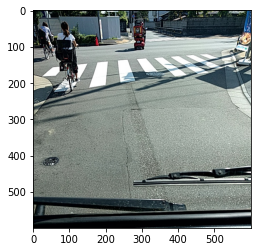

In [42]:
image_file_path = "/content/RoadDamageDataset/Adachi/JPEGImages/Adachi_20170908142224.jpg"
img = cv2.imread(image_file_path)
height, width, channels = img.shape

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [0]:
input_size = 300
transform = DataTransform(input_size)
phase = "val"
img_transformed, boxes, labels = transform(img, "", "")
img = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

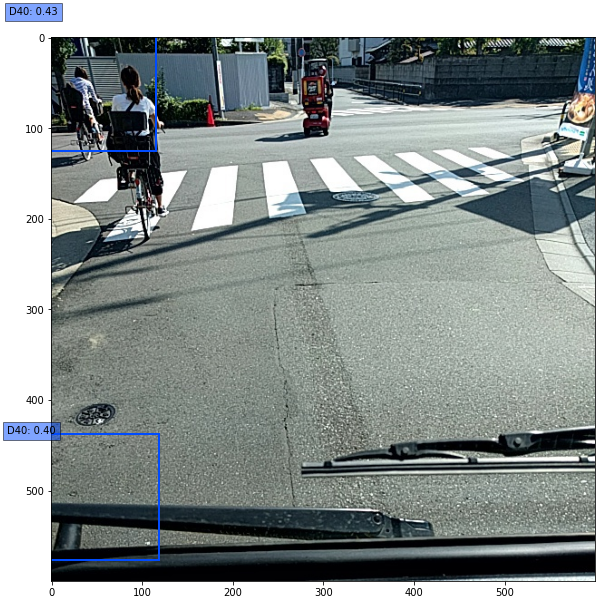

In [45]:
model.eval()
x = img.unsqueeze(0)

detections = model(x)

# ひびの割れ方のクラス
damage_class=["D00", "D01", "D10", "D11", "D20", "D40", "D43", "D44", "30"]

ssd = SSDPredictShow(eval_categories=damage_class, net=model)
ssd.show(image_file_path, data_confidence_level=0.4)